In [7]:
# jack tarricone
# november 2nd, 2021 

# convert InSAR .tiff converter to a PolSAR one

In [4]:
import os
import re
import codecs
import rasterio as rio
import numpy
import matplotlib
from matplotlib import pyplot as plt
import glob
import subprocess
from osgeo import gdal

In [36]:
# folder is path to a folder with an .ann (or .txt) and .hgt (dem), .inc (incidence angle), .slope

def polsar_tiff_convert(folder):
    """
     Builds a header file for the input UAVSAR .inc file,
    allowing the data to be read as a raster dataset.
    :param folder:   the folder containing the UAVSAR .inc and .ann files
    """
    os.chdir(folder)
    
    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Latitude_list = []
    Longitude_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".inc":
            newfile = open(files[0:-4] + ".hdr", 'w')
            newfile.write("""ENVI
description = {DESCFIELD}
samples = NSAMP
lines = NLINE
bands = 1
header offset = 0
data type = DATTYPE
interleave = bsq
sensor type = UAVSAR L-Band
byte order = 0
map info = {Geographic Lat/Lon, 
            1.000, 
            1.000, 
            LON, 
            LAT,  
            0.0000555600000000, 
            0.0000555600000000, 
            WGS-84, units=Degrees}
wavelength units = Unknown
                """
                          )
            newfile.close()
            if files[0:18] not in Files_list:
                Files_list.append(files[0:18])

    #Variables used to recall indexed values.
    var1 = 0

    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types.
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "inc.set_rows" in line:
                    Lines = line[64:70]
                    print(f"Number of Lines: {Lines}")
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "inc.set_cols" in line:
                    Samples = line[64:70]
                    print(f"Number of Samples: {Samples}")
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)

                elif "inc.row_addr" in line:
                    Latitude = line[64:85]
                    print(f"Top left lat: {Latitude}")
                    if Latitude not in Latitude_list:
                        Latitude_list.append(Latitude)

                elif "inc.col_addr" in line:
                    Longitude = line[64:85]
                    print(f"Top left Lon: {Longitude}")
                    if Longitude not in Longitude_list:
                        Longitude_list.append(Longitude)
    
                        
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data for all type 4 (real numbers) data
    # this all the .inc files
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "data type = DATTYPE" in line:
                        sources.write(re.sub(line[12:19], "4", line))
                    elif "DESCFIELD" in line:
                        sources.write(re.sub(line[15:24], folder, line))
                    elif "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    elif "LAT" in line:
                        sources.write(re.sub(line[12:15], Latitude, line))
                    elif "LON" in line:
                        sources.write(re.sub(line[12:15], Longitude, line))
                    else:
                        sources.write(re.sub(line, line, line))
    

                        
    
    # Step 4: Now we have an .hdr file, the data is geocoded and can be loaded into python gdal
    # once loaded in we use gdal.Translate to convert and save as a .tiff
    
    types = ('*.inc', '*.slope','*.hgt') # the tuple of file types
    files_grabbed = []
    for files in types:
        files_grabbed.extend(glob.glob(files))

    
    data_to_process = glob.glob(os.path.join(folder, '*.inc')) + glob.glob(os.path.join(folder, '*.slope')) + glob.glob(os.path.join(folder, '*.hgt')) 
    for data_path in data_to_process: # loop to open and translate .inc to .tiff, and save .tiffs using gdal
        raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
        raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.tiff'), raster_dataset, format = 'Gtiff', outputType = gdal.GDT_Float32)
    

    print(".tiffs have been created")
    return



In [33]:
data_to_process = glob.glob(os.path.join(folder, '*.inc')) + glob.glob(os.path.join(folder, '*.slope')) 
print(data_to_process)

['/Users/jacktarricone/Desktop/rocky/rockmt_14107_21021_002_210322_L090_CX_01.inc', '/Users/jacktarricone/Desktop/rocky/rockmt_14107_21021_002_210322_L090_CX_01.slope']


In [38]:
folder = "/Users/jacktarricone/Desktop/rocky/" 
os.listdir(folder)

['rockmt_14107_21021_002_210322_L090_CX_01.inc',
 'rockmt_14107_21021_002_210322_L090_CX_01.inc.tiff',
 '.DS_Store',
 'rockmt_14107_21021_002_210322_L090_CX_01.hgt',
 'rockmt_14107_21021_002_210322_L090_CX_01.ann.txt',
 'rockmt_14107_21021_002_210322_L090_CX_01.hdr',
 'rockmt_14107_21021_002_210322_L090_CX_01.slope.tiff',
 'rockmt_14107_21021_002_210322_L090_CX_01.slope',
 'rockmt_14107_21021_002_210322_L090_CX_01.hgt.tiff']

In [37]:
polsar_tiff_convert(folder)

Number of Lines: 8806  
Number of Samples: 10520 
Top left lat: 40.77781752          
Top left Lon: -106.16921508        
.tiffs have been created


In [32]:
### inspect our newly created .tiffs, and create named objects for each data type. We'll use these new obects in the next step

# amplitude from the first acquisition
for amp1 in glob.glob("*amp1.grd.tiff"):
    print(amp1)
    
# amplitude from the second acquisition
for amp2 in glob.glob("*amp2.grd.tiff"):
    print(amp2)

# coherence
for cor in glob.glob("*cor.grd.tiff"):
    print(cor)

# unwrapped phase
for unw in glob.glob("*unw.grd.tiff"):
    print(unw)

# dem used in processing
for dem in glob.glob("*hgt.grd.tiff"):
    print(dem)

irnton_01406_21016-003_21018-003_0007d_s01_L090HH_01.amp1.grd.tiff
irnton_01406_21016-003_21018-003_0007d_s01_L090HH_01.amp2.grd.tiff
irnton_01406_21016-003_21018-003_0007d_s01_L090HH_01.cor.grd.tiff
irnton_01406_21016-003_21018-003_0007d_s01_L090HH_01.unw.grd.tiff


In [33]:
cor_rast = rio.open(cor)
cor_meta = cor_rast.profile
print(cor_meta)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 6467, 'height': 8395, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.556e-05, 0.0, -107.91402132,
       0.0, -5.556e-05, 38.1263832), 'tiled': False, 'interleave': 'band'}


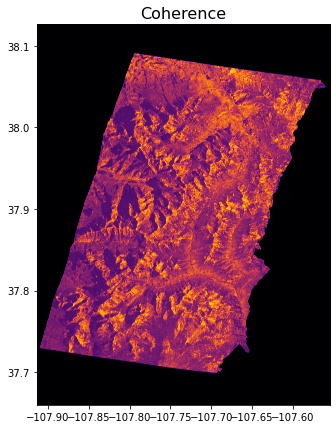

In [34]:
cor_rast = rio.open(cor)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Coherence",fontsize = 16);
show((cor_rast, 1), cmap = 'inferno', vmin = 0, vmax = 1);

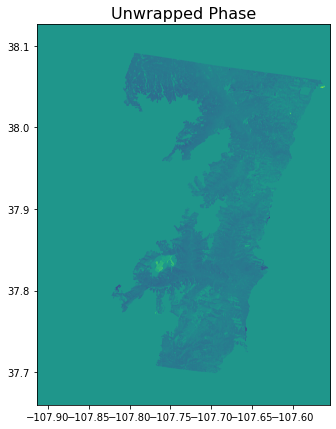

In [35]:
unw_rast = rio.open(unw)
fig, ax = plt.subplots(figsize = (10,7))
ax.set_title("Unwrapped Phase",fontsize = 16);
show((unw_rast, 1), cmap = 'viridis'); # info from histogram